# Stroke Prediction v4 - Pipeline de Producao

In [1]:
# === 1. CONFIGURACAO ===
from pathlib import Path
import sys

sys.path.insert(0, str(Path('.').resolve() / 'src'))

from src import (
    load_and_validate_data, engineer_medical_features,
    create_preprocessing_pipeline, train_model_suite,
    evaluate_model_comprehensive, analyze_fairness,
    monitor_drift, save_model_with_metadata
)
from src.calibration import calibrate_model_comprehensive, plot_calibration_curve
from src.evaluation import summarize_threshold_performance, summarize_threshold_grid
from src.clinical_utility import decision_curve_analysis, plot_decision_curve
from src.visualization import (
    plot_model_comparison_comprehensive,
    plot_calibration_analysis,
    plot_confusion_matrices
)
# Import new fairness audit module
from src.fairness_audit import (
    audit_fairness_baseline,
    mitigate_fairness_staged,
    generate_fairness_report
)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

print('Ambiente carregado com sucesso')
print(f"Diretorio de trabalho: {Path('.').resolve()}")


Ambiente carregado com sucesso
Diretorio de trabalho: C:\Users\argus.portal\workspace\StrokePrediction


In [2]:
# === 2. CARREGAMENTO E VALIDACAO ===
df, metadata = load_and_validate_data()

print('Informacoes do conjunto:')
print(f"   Formato: {metadata['shape']}")
print(f"   Prevalencia: {metadata['prevalence']:.3%}")
print(f"   Checksum: {metadata['checksum']}")

df.head()


Informacoes do conjunto:
   Formato: (5110, 12)
   Prevalencia: 4.873%
   Checksum: 9ea7d504d421cebe


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# === 3. FEATURE ENGINEERING ===
df_enhanced = engineer_medical_features(df)

novas = [c for c in df_enhanced.columns if c not in df.columns]
print(f"Foram geradas {len(novas)} novas variaveis")

df_enhanced.head()


Foram geradas 20 novas variaveis


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,...,glucose_age_risk,smoking_status_clean,smoking_risk,is_smoker,gender_clean,gender_risk,high_stress_job,total_risk_score,age_hypertension_int,metabolic_syndrome
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,...,15.32223,formerly smoked,1,0,Male,1,1,11,0.0,1
1,Female,61.0,0,0,Yes,Private,Rural,202.21,28.1,never smoked,...,12.33481,never smoked,0,0,Female,0,1,2,0.0,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,...,8.47360,never smoked,0,0,Male,1,1,8,0.0,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,...,8.39027,smokes,2,1,Female,0,1,5,0.0,1
4,Female,79.0,1,0,Yes,Private,Rural,174.12,24.0,never smoked,...,13.75548,never smoked,0,0,Female,0,1,7,79.0,0


📊 DISTRIBUICAO DO TARGET:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64
📈 VALORES AUSENTES:
Series([], dtype: int64)
🔗 MAIORES CORRELACOES COM O TARGET:
stroke                  1.000000
age_squared             0.274620
cardio_risk_score       0.266467
is_elderly              0.247136
total_risk_score        0.246581
glucose_age_risk        0.246558
age                     0.245257
bmi_age_interaction     0.212057
age_hypertension_int    0.149634
heart_disease           0.134914
dtype: float64


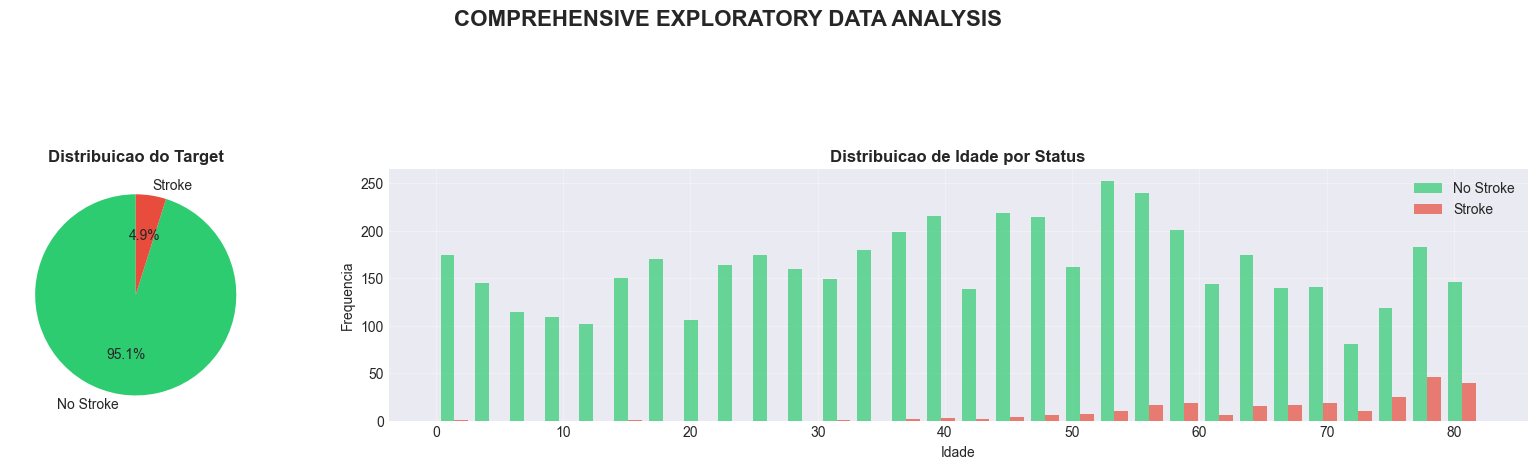

📋 ESTATISTICAS RESUMO POR STATUS:


age               avg_glucose_level                   bmi        \
         mean    std median              mean    std  median   mean   std   
stroke                                                                      
0       41.97  22.29   43.0            104.80  43.85   91.47  28.80  7.78   
1       67.73  12.73   71.0            132.54  61.92  105.22  30.09  5.86   

               
       median  
stroke         
0        28.1  
1        28.1

C:\Users\argus.portal\AppData\Local\Temp\ipykernel_102056\1136014854.py:103: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\argus.portal\workspace\StrokePrediction\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


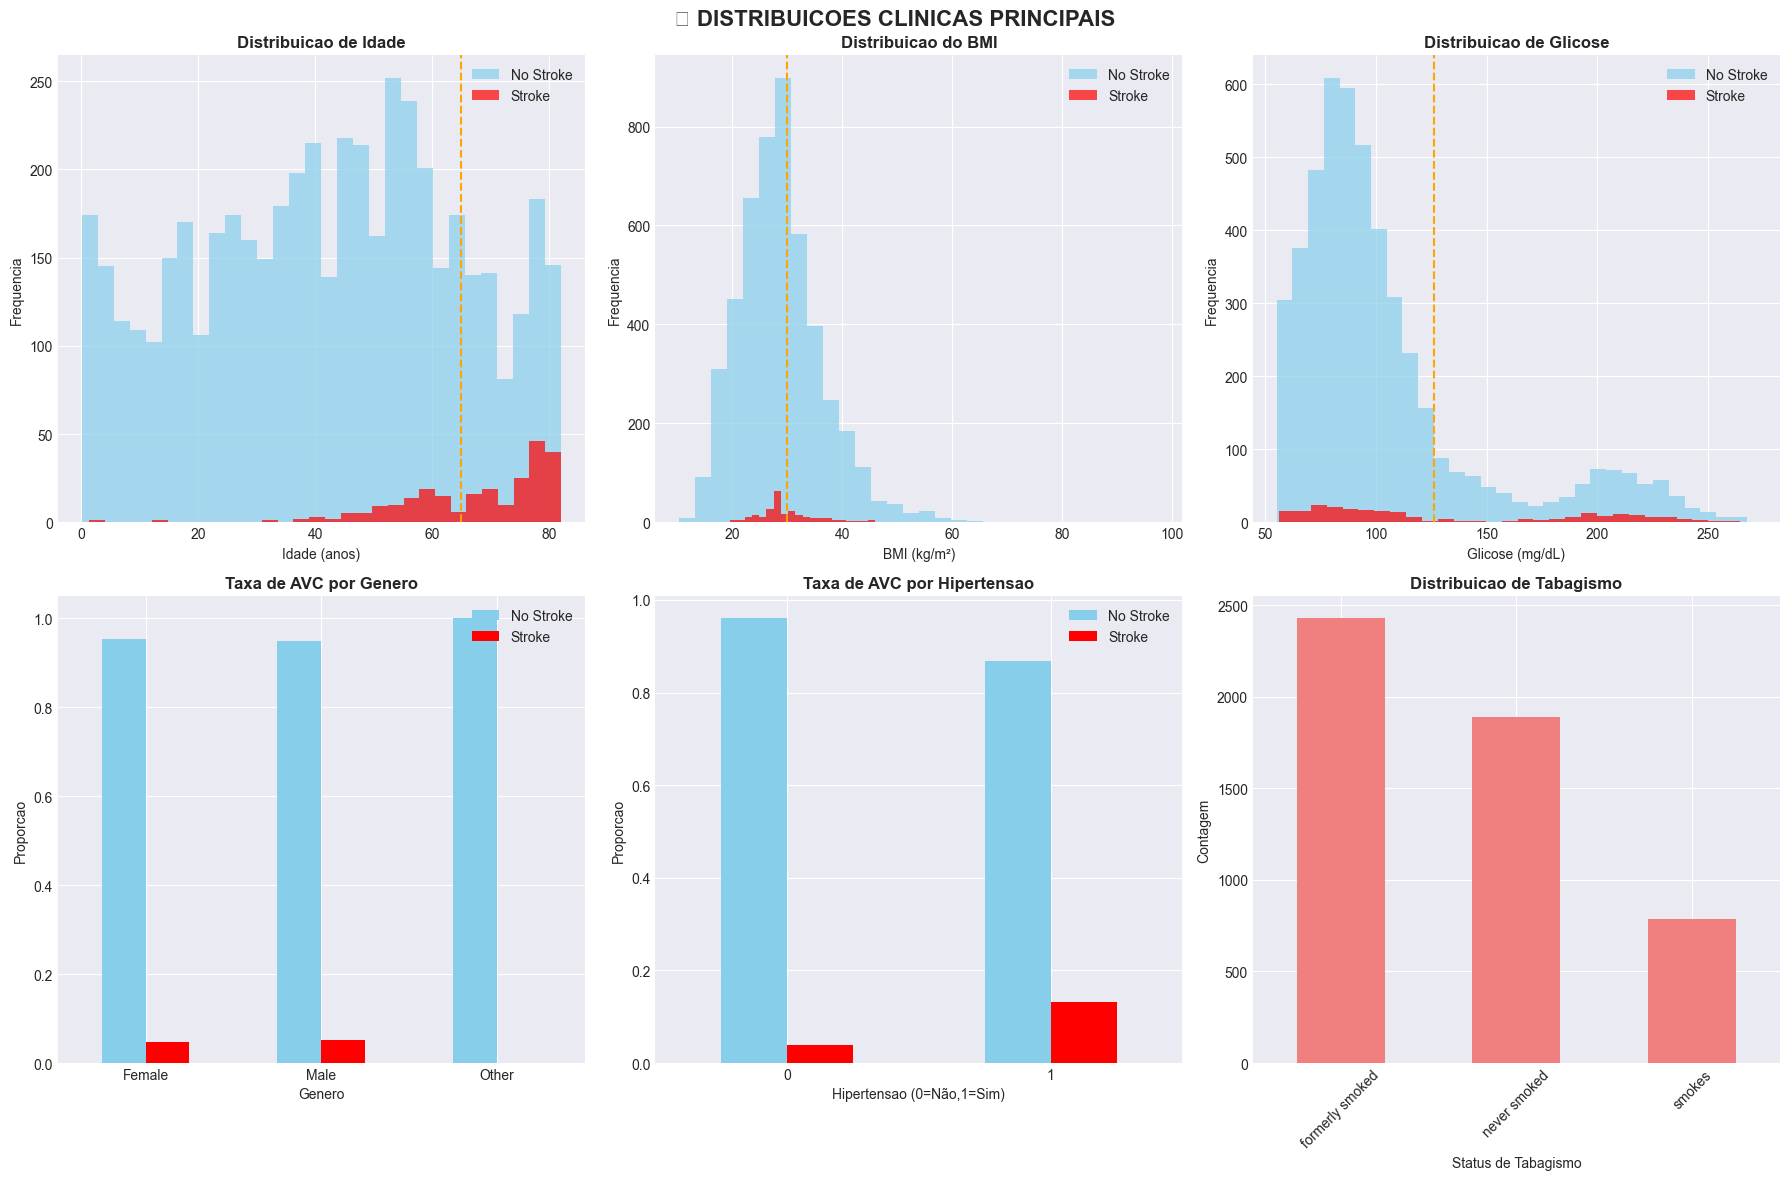

C:\Users\argus.portal\AppData\Local\Temp\ipykernel_102056\1136014854.py:115: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\argus.portal\workspace\StrokePrediction\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


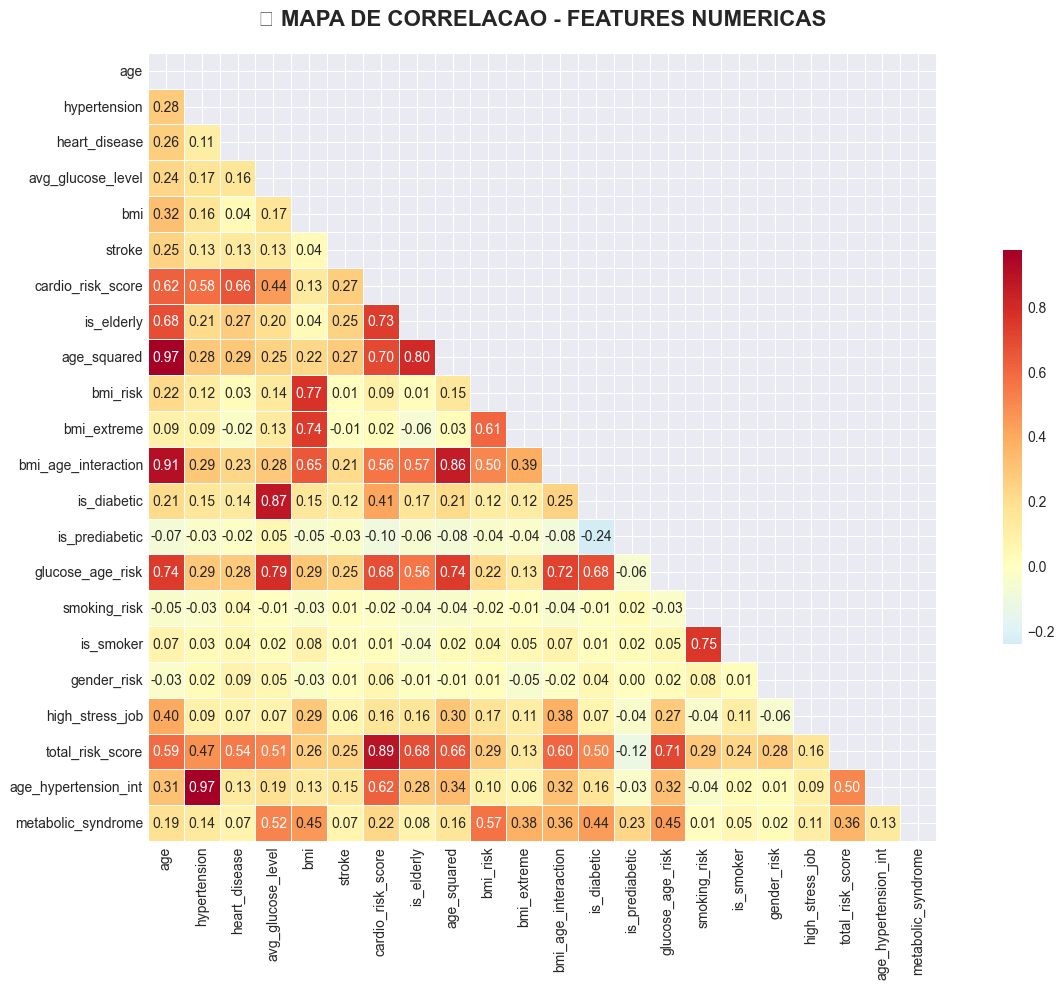

C:\Users\argus.portal\AppData\Local\Temp\ipykernel_102056\1136014854.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stroke_risk = df_temp.groupby('risk_bin')[target].agg(['count', 'mean'])
C:\Users\argus.portal\AppData\Local\Temp\ipykernel_102056\1136014854.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stroke_risk = df_temp.groupby('risk_bin')[target].agg(['count', 'mean'])
C:\Users\argus.portal\AppData\Local\Temp\ipykernel_102056\1136014854.py:189: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout(rect=(0, 0.04, 1, 0.96))
C:\Users\argus.portal\AppData\Loc

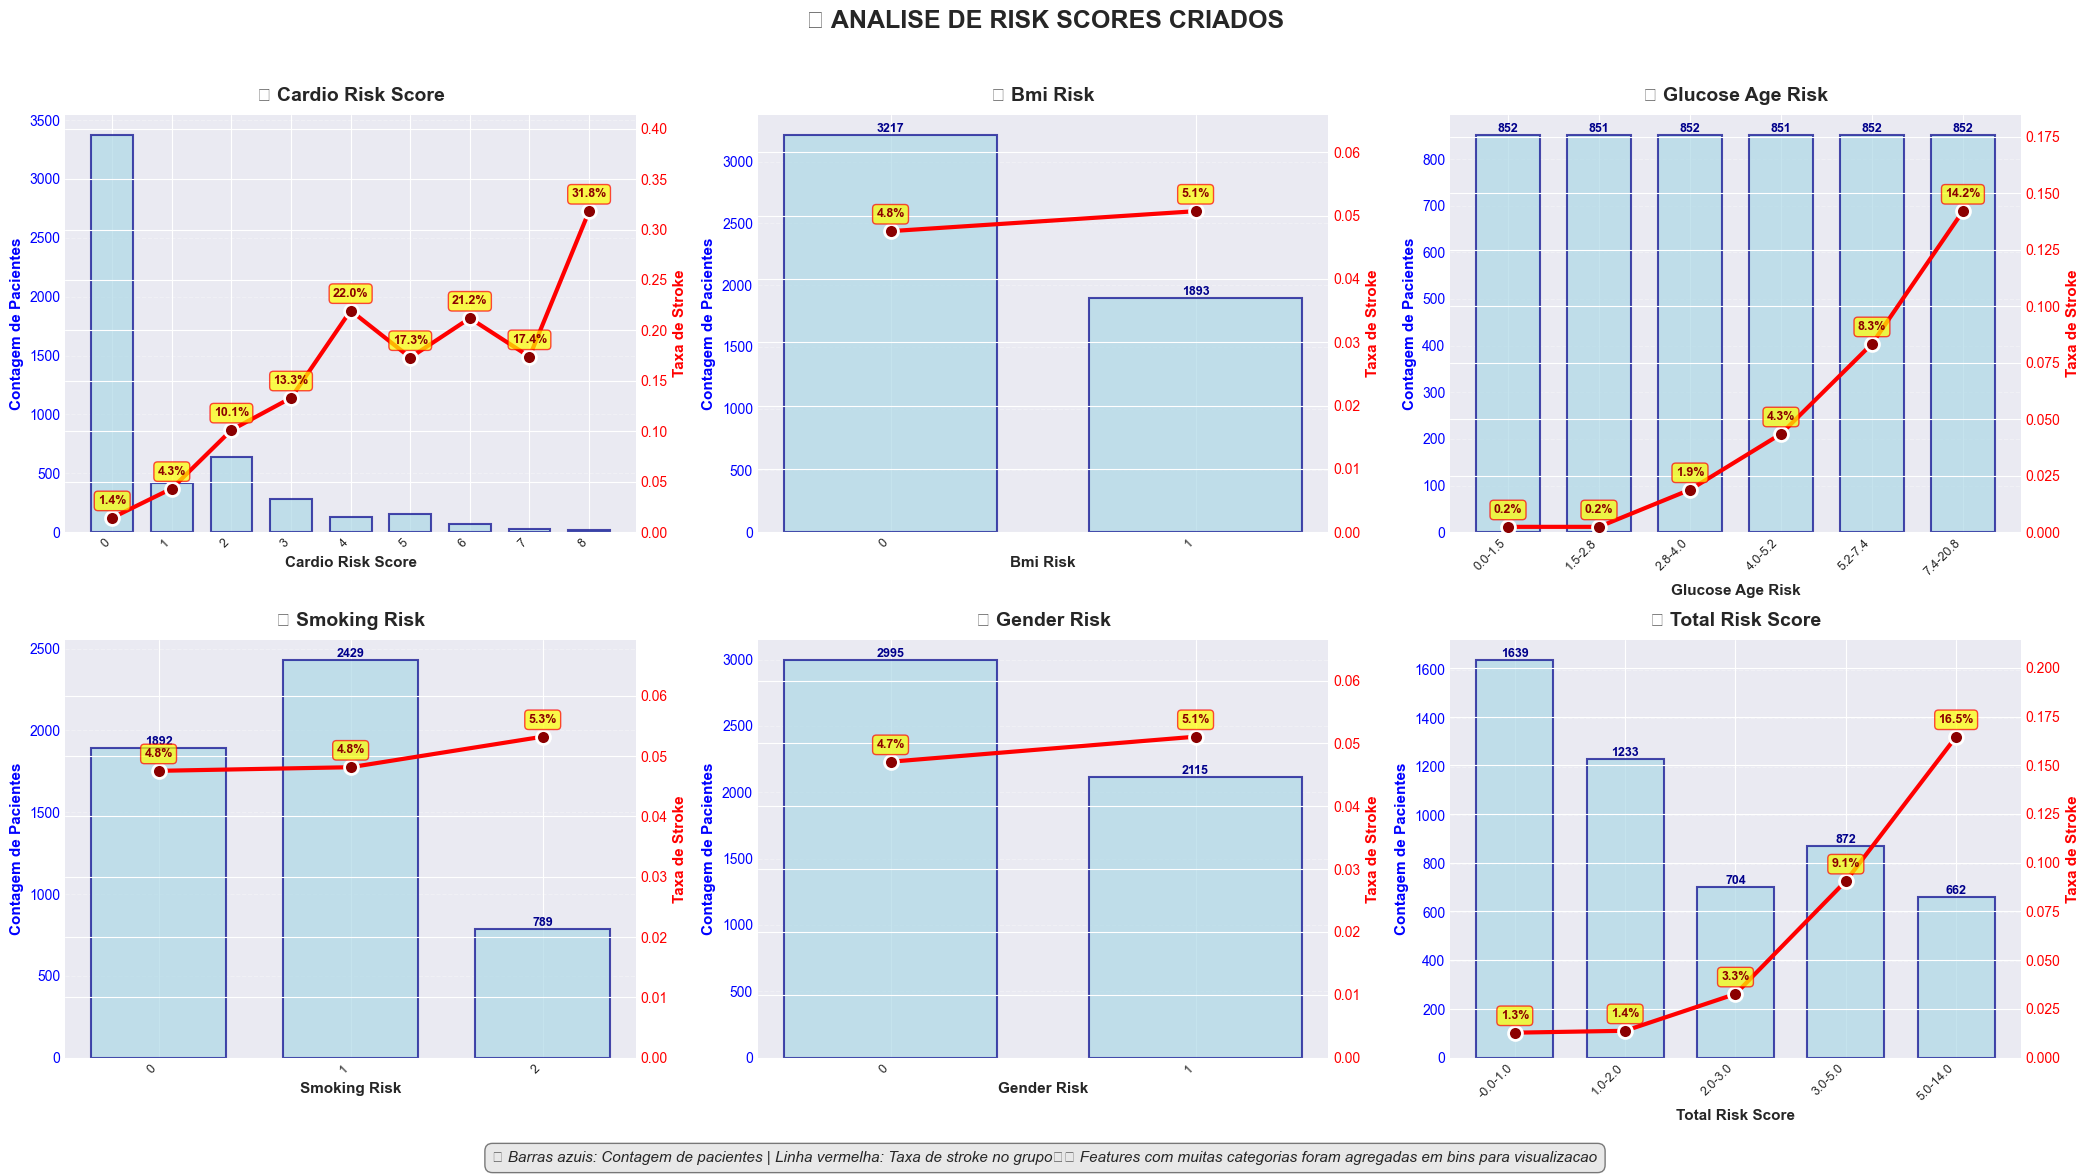

📊 RESUMO DOS RISK SCORES:
🎯 CARDIO_RISK_SCORE:
   Range de taxa de stroke: 1.42% → 31.82%
   Variacao total: 30.40%
   Categorias originais: 9
   🔴 Maior risco: Categoria 8 (31.82%)
🎯 BMI_RISK:
   Range de taxa de stroke: 4.76% → 5.07%
   Variacao total: 0.32%
   Categorias originais: 2
   🔴 Maior risco: Categoria 1 (5.07%)
🎯 GLUCOSE_AGE_RISK:
   Range de taxa de stroke: 0.00% → 100.00%
   Variacao total: 100.00%
   Categorias originais: 5077
   ⚠️ Feature agregada em bins para visualizacao (muitas categorias)
   🔴 Maior risco: Categoria 0.09288840000000001 (100.00%)
🎯 SMOKING_RISK:
   Range de taxa de stroke: 4.76% → 5.32%
   Variacao total: 0.57%
   Categorias originais: 3
   🔴 Maior risco: Categoria 2 (5.32%)
🎯 GENDER_RISK:
   Range de taxa de stroke: 4.71% → 5.11%
   Variacao total: 0.40%
   Categorias originais: 2
   🔴 Maior risco: Categoria 1 (5.11%)
🎯 TOTAL_RISK_SCORE:
   Range de taxa de stroke: 1.03% → 100.00%
   Variacao total: 98.97%
   Categorias originais: 15
   ⚠️ Feature

In [4]:
from pathlib import Path
if 'RESULTS_PATH' not in globals():
    RESULTS_PATH = Path('results')
    RESULTS_PATH.mkdir(parents=True, exist_ok=True)
if 'RESULTS_PATH' not in globals():
    RESULTS_PATH = Path('results')
    RESULTS_PATH.mkdir(parents=True, exist_ok=True)


# === 3B. EXPLORACAO DE DADOS ===
import matplotlib.pyplot as plt
import seaborn as sns

target = 'stroke'

print('📊 DISTRIBUICAO DO TARGET:')
target_counts = df_enhanced[target].value_counts(normalize=True)
print(target_counts)

print('📈 VALORES AUSENTES:')
missing = df_enhanced.isnull().sum()
print(missing[missing > 0])

print('🔗 MAIORES CORRELACOES COM O TARGET:')
numeric_cols = df_enhanced.select_dtypes(include=[np.number]).columns
correlations = df_enhanced[numeric_cols].corrwith(df_enhanced[target]).abs().sort_values(ascending=False)
print(correlations.head(10))

# --- Painel principal ---
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# 1. Distribuicao do target
ax1 = fig.add_subplot(gs[0, 0])
target_counts_abs = df_enhanced[target].value_counts()
colors = ['#2ecc71', '#e74c3c']
ax1.pie(target_counts_abs, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('Distribuicao do Target', fontweight='bold', fontsize=12)

# 2. Idade por status
ax2 = fig.add_subplot(gs[0, 1:])
age_no_stroke = df_enhanced[df_enhanced[target] == 0]['age'].dropna()
age_stroke = df_enhanced[df_enhanced[target] == 1]['age'].dropna()
ax2.hist([age_no_stroke, age_stroke], bins=30, alpha=0.7,
         label=['No Stroke', 'Stroke'], color=['#2ecc71', '#e74c3c'])
ax2.set_xlabel('Idade'); ax2.set_ylabel('Frequencia')
ax2.set_title('Distribuicao de Idade por Status', fontweight='bold', fontsize=12)
ax2.legend(); ax2.grid(alpha=0.3)

plt.suptitle('COMPREHENSIVE EXPLORATORY DATA ANALYSIS', fontsize=16, fontweight='bold')
#plt.savefig(RESULTS_PATH / 'eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print('📋 ESTATISTICAS RESUMO POR STATUS:')
summary_stats = df_enhanced.groupby(target)[['age', 'avg_glucose_level', 'bmi']].agg(['mean', 'std', 'median'])
display(summary_stats.round(2))

# --- Distribuicoes principais ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📊 DISTRIBUICOES CLINICAS PRINCIPAIS', fontsize=16, fontweight='bold')

ax = axes[0, 0]
df_enhanced[df_enhanced[target] == 0]['age'].hist(bins=30, alpha=0.7, color='skyblue', label='No Stroke', ax=ax)
df_enhanced[df_enhanced[target] == 1]['age'].hist(bins=30, alpha=0.7, color='red', label='Stroke', ax=ax)
ax.set_title('Distribuicao de Idade', fontweight='bold')
ax.set_xlabel('Idade (anos)'); ax.set_ylabel('Frequencia')
ax.legend(); ax.axvline(65, color='orange', linestyle='--', label='65 anos')

ax = axes[0, 1]
df_enhanced[df_enhanced[target] == 0]['bmi'].hist(bins=30, alpha=0.7, color='skyblue', label='No Stroke', ax=ax)
df_enhanced[df_enhanced[target] == 1]['bmi'].hist(bins=30, alpha=0.7, color='red', label='Stroke', ax=ax)
ax.set_title('Distribuicao do BMI', fontweight='bold')
ax.set_xlabel('BMI (kg/m²)'); ax.set_ylabel('Frequencia')
ax.legend(); ax.axvline(30, color='orange', linestyle='--', label='Obesidade')

ax = axes[0, 2]
df_enhanced[df_enhanced[target] == 0]['avg_glucose_level'].hist(bins=30, alpha=0.7, color='skyblue', label='No Stroke', ax=ax)
df_enhanced[df_enhanced[target] == 1]['avg_glucose_level'].hist(bins=30, alpha=0.7, color='red', label='Stroke', ax=ax)
ax.set_title('Distribuicao de Glicose', fontweight='bold')
ax.set_xlabel('Glicose (mg/dL)'); ax.set_ylabel('Frequencia')
ax.legend(); ax.axvline(126, color='orange', linestyle='--', label='Diabetes (126)')

ax = axes[1, 0]
gender_stroke = pd.crosstab(df_enhanced['gender'], df_enhanced[target], normalize='index')
gender_stroke.plot(kind='bar', ax=ax, color=['skyblue', 'red'], rot=0)
ax.set_title('Taxa de AVC por Genero', fontweight='bold')
ax.set_xlabel('Genero'); ax.set_ylabel('Proporcao')
ax.legend(['No Stroke', 'Stroke'])

ax = axes[1, 1]
hyp_stroke = pd.crosstab(df_enhanced['hypertension'], df_enhanced[target], normalize='index')
hyp_stroke.plot(kind='bar', ax=ax, color=['skyblue', 'red'], rot=0)
ax.set_title('Taxa de AVC por Hipertensao', fontweight='bold')
ax.set_xlabel('Hipertensao (0=Não,1=Sim)'); ax.set_ylabel('Proporcao')
ax.legend(['No Stroke', 'Stroke'])

ax = axes[1, 2]
df_enhanced['smoking_status'].value_counts().plot(kind='bar', ax=ax, color='lightcoral', rot=45)
ax.set_title('Distribuicao de Tabagismo', fontweight='bold')
ax.set_xlabel('Status de Tabagismo'); ax.set_ylabel('Contagem')

plt.tight_layout()
#plt.savefig(RESULTS_PATH / 'clinical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Heatmap de correlacao ---
numeric_features = df_enhanced.select_dtypes(include=[np.number]).columns
correlation_matrix = df_enhanced[numeric_features].corr()
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, fmt='.2f', cbar_kws={'shrink': .5})
plt.title('🔗 MAPA DE CORRELACAO - FEATURES NUMERICAS', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
#plt.savefig(RESULTS_PATH / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Analise de risk scores ---
risk_features = [col for col in df_enhanced.columns if 'risk' in col or 'score' in col]

if risk_features:
    n_features = len(risk_features)
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 6*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    axes_flat = axes.flatten()

    for idx, risk_feat in enumerate(risk_features):
        ax = axes_flat[idx]
        stroke_risk = df_enhanced.groupby(risk_feat)[target].agg(['count', 'mean'])
        if len(stroke_risk) > 10:
            try:
                bins = pd.qcut(df_enhanced[risk_feat], q=6, duplicates='drop')
                df_temp = df_enhanced[[risk_feat, target]].copy()
                df_temp['risk_bin'] = bins
                stroke_risk = df_temp.groupby('risk_bin')[target].agg(['count', 'mean'])
                x_labels = [f'{interval.left:.1f}-{interval.right:.1f}' for interval in stroke_risk.index]
            except ValueError:
                bins = pd.cut(df_enhanced[risk_feat], bins=6)
                df_temp = df_enhanced[[risk_feat, target]].copy()
                df_temp['risk_bin'] = bins
                stroke_risk = df_temp.groupby('risk_bin')[target].agg(['count', 'mean'])
                x_labels = [f'{interval.left:.1f}-{interval.right:.1f}' for interval in stroke_risk.index]
        else:
            x_labels = stroke_risk.index.tolist()
        x_positions = range(len(stroke_risk))
        ax2 = ax.twinx()
        bars = ax.bar(x_positions, stroke_risk['count'], color='lightblue', alpha=0.7, width=0.7, edgecolor='darkblue', linewidth=1.5)
        ax2.plot(x_positions, stroke_risk['mean'], color='red', marker='o', linewidth=3, markersize=10,
                 markerfacecolor='darkred', markeredgecolor='white', markeredgewidth=2, label='Taxa de Stroke')
        ax.set_title(f'📊 {risk_feat.replace('_', ' ').title()}', fontweight='bold', fontsize=14, pad=10)
        ax.set_xlabel(risk_feat.replace('_', ' ').title(), fontweight='bold', fontsize=11)
        ax.set_ylabel('Contagem de Pacientes', color='blue', fontweight='bold', fontsize=11)
        ax2.set_ylabel('Taxa de Stroke', color='red', fontweight='bold', fontsize=11)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
        ax.tick_params(axis='y', labelcolor='blue', labelsize=10)
        ax2.tick_params(axis='y', labelcolor='red', labelsize=10)
        ax.grid(True, alpha=0.3, axis='y', linestyle='--'); ax.set_axisbelow(True)

        if len(x_positions) <= 8:
            for bar, count in zip(bars, stroke_risk['count']):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height,
                        f'{int(count)}', ha='center', va='bottom', fontweight='bold', fontsize=9, color='darkblue')
        for x_pos, rate in zip(x_positions, stroke_risk['mean']):
            ax2.annotate(f'{rate:.1%}', xy=(x_pos, rate), xytext=(0, 10), textcoords='offset points',
                         ha='center', fontweight='bold', fontsize=9, color='darkred',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='red', linewidth=1))
        y2_max = stroke_risk['mean'].max()
        ax2.set_ylim(0, max(0.05, y2_max * 1.3))

    for idx in range(len(risk_features), len(axes_flat)):
        axes_flat[idx].set_visible(False)

    fig.suptitle('🎯 ANALISE DE RISK SCORES CRIADOS', fontsize=18, fontweight='bold', y=0.98)
    fig.text(0.5, 0.02,
             '📌 Barras azuis: Contagem de pacientes | Linha vermelha: Taxa de stroke no grupo'
             '⚠️ Features com muitas categorias foram agregadas em bins para visualizacao',
             ha='center', fontsize=11, style='italic',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.5))
    plt.tight_layout(rect=(0, 0.04, 1, 0.96))
 #   plt.savefig(RESULTS_PATH / 'risk_scores_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print('📊 RESUMO DOS RISK SCORES:')
    print('=' * 70)
    for risk_feat in risk_features:
        stroke_risk_orig = df_enhanced.groupby(risk_feat)[target].mean()
        max_risk = stroke_risk_orig.max()
        min_risk = stroke_risk_orig.min()
        risk_range = max_risk - min_risk
        n_categories = len(stroke_risk_orig)

        print(f'🎯 {risk_feat.upper()}:')
        print(f'   Range de taxa de stroke: {min_risk:.2%} → {max_risk:.2%}')
        print(f'   Variacao total: {risk_range:.2%}')
        print(f'   Categorias originais: {n_categories}')

        if n_categories > 10:
            print('   ⚠️ Feature agregada em bins para visualizacao (muitas categorias)')

        highest_risk_cat = stroke_risk_orig.idxmax()
        print(f'   🔴 Maior risco: Categoria {highest_risk_cat} ({stroke_risk_orig[highest_risk_cat]:.2%})')
else:
    print('⚠️ Nenhuma feature com "risk" ou "score" para analise adicional.')



In [5]:
# === 4. STRATIFIED SPLITS ===
X = df_enhanced.drop(columns=['stroke'])
y = df_enhanced['stroke'].astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1875, stratify=y_temp, random_state=42
)

print('Distribuicoes:')
for nome, target in [('Treino', y_train), ('Validacao', y_val), ('Teste', y_test)]:
    print(f"   {nome}: n={len(target)}, prevalencia={target.mean():.3f}")


Distribuicoes:
   Treino: n=3321, prevalencia=0.049
   Validacao: n=767, prevalencia=0.048
   Teste: n=1022, prevalencia=0.049


In [6]:
# === 5. PIPELINE DE PRE-PROCESSAMENTO ===
preprocessor, feature_info = create_preprocessing_pipeline(X_train)

print(f"Pipeline configurado com {feature_info['n_features_in']} variaveis de entrada")


Pipeline configurado com 30 variaveis de entrada


In [ ]:
# === 6. TREINAMENTO ===
results, ranking, summary_df = train_model_suite(
    X_train, y_train, X_val, y_val, preprocessor, cv_folds=10
)

best_name, best_result = ranking[0]
best_model = best_result['model']
production_threshold = best_result.get('production_threshold', 0.5)

print(f"\nMelhor modelo: {best_name.upper()}")
print(f"   Limiar inicial: {production_threshold:.3f} (fonte: {best_result.get('production_threshold_source')})")
summary_df


🤖 INICIANDO TREINAMENTO DE MODELOS
Augmented critical groups -> total train samples 3439

📊 Treinando 1 modelos com 10-fold CV (repeats=2)...


🔧 Modelo: LOGISTIC_L2

🔍 Busca de hiperparâmetros (RandomizedSearchCV, n_iter=15)


In [ ]:
# === 7. CALIBRACAO ===
best_model_calibrated, calibration_report = calibrate_model_comprehensive(
    model=best_model,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    cv_folds=10,
    deployment_threshold=None
)

y_proba_val_cal = best_model_calibrated.predict_proba(X_val)[:, 1]
results[best_name]['calibration_report'] = calibration_report
results[best_name]['y_proba_calibrated_val'] = y_proba_val_cal

post_cal = calibration_report.get('post_calibration', {})
if post_cal:
    ece_value = float(post_cal.get('ece', float('nan')))
    brier_value = float(post_cal.get('brier_score', float('nan')))
    bss_value = float(post_cal.get('bss', float('nan')))

    print(f"ECE (pos-calibracao): {ece_value:.4f}")
    print(f"Brier Score (pos-calibracao): {brier_value:.4f}")
    print(f"BSS (pos-calibracao): {bss_value:.4f}")

    calibration_status = {
        'ece': ece_value,
        'brier': brier_value,
        'bss': bss_value,
        'acceptable': bool(ece_value < 0.05),
        'resolution_flag': bool(bss_value < 0.10)
    }

    if calibration_status['acceptable']:
        print('✅ Calibracao aceita (ECE < 0.05).')
    else:
        print('⚠️ Calibracao fora da meta (ECE >= 0.05).')

    if calibration_status['resolution_flag']:
        print('⚠️ BSS < 0.10 - sugerido plano para melhorar resolucao (features/ensemble/calibracao segmentada).')
    else:
        print('✅ BSS atende a meta de resolucao (>= 0.10).')

    results[best_name]['calibration_assessment'] = calibration_status
else:
    print('Metricas pos-calibracao indisponiveis')
    results[best_name]['calibration_assessment'] = None

plot_calibration_curve(best_model_calibrated, X_val, y_val, f'{best_name}_calibrated')



In [ ]:
# === 8. DECISION CURVE ANALYSIS ===
y_proba_dca = y_proba_val_cal
dca_results, optimal_threshold_dca = decision_curve_analysis(
    y_true=y_val,
    y_proba=y_proba_dca,
    threshold_range=np.arange(0.05, 0.35, 0.01),
    model_name=f'{best_name}_calibrated'
)

plot_decision_curve(dca_results, f'{best_name}_calibrated')
print(f"Threshold otimo (DCA): {optimal_threshold_dca:.3f}")


In [ ]:
# === 10. NET BENEFIT ANALYSIS ===
clinical_window = (0.08, 0.15)
prevalence_val = y_val.mean()
prevalence_test = y_test.mean()

production_metrics_val = best_result.get('production_threshold_metrics_val') or {}
threshold_rationale = results[best_name].setdefault('threshold_rationale', {})
precision_min = threshold_rationale.get('precision_min', globals().get('precision_min'))
if isinstance(precision_min, float) and np.isnan(precision_min):
    precision_min = None
if precision_min is None:
    precision_min = production_metrics_val.get('precision')
if precision_min is None:
    precision_min = 0.0
precision_min = float(precision_min)

recall_min = threshold_rationale.get('recall_min', globals().get('recall_min'))
if isinstance(recall_min, float) and np.isnan(recall_min):
    recall_min = None
if recall_min is None:
    recall_min = production_metrics_val.get('recall')
if recall_min is None:
    recall_min = 0.0
recall_min = float(recall_min)

threshold_rationale['precision_min'] = precision_min
threshold_rationale['recall_min'] = recall_min

from src.evaluation import summarize_threshold_grid
if 'y_proba_test' not in globals():
    y_proba_test = best_model_calibrated.predict_proba(X_test)[:, 1]
threshold_sweep = np.round(np.arange(0.01, 0.51, 0.01), 2)
threshold_grid_val = summarize_threshold_grid(y_val, y_proba_val_cal, threshold_sweep)
threshold_grid_test = summarize_threshold_grid(y_test, y_proba_test, threshold_sweep)

def _net_benefit(df, prevalence):
    rows = []
    for _, row in df.iterrows():
        pt = float(row['threshold'])
        odds = pt / (1.0 - pt) if pt < 1 else float('inf')
        tp = float(row.get('tp', 0.0))
        fp = float(row.get('fp', 0.0))
        tn = float(row.get('tn', 0.0))
        fn = float(row.get('fn', 0.0))
        n = tp + fp + tn + fn
        if n == 0 or odds == float('inf'):
            continue
        nb_model = (tp / n) - (fp / n) * odds
        nb_all = prevalence - (1 - prevalence) * odds
        nb_none = 0.0
        tp_per_1000 = nb_model * 1000.0
        interventions = ((nb_model - nb_all) / odds) * 1000.0 if odds > 0 else float('nan')
        rows.append({
            'threshold': pt,
            'precision': float(row.get('precision', float('nan'))),
            'recall': float(row.get('recall', float('nan'))),
            'net_benefit': nb_model,
            'net_benefit_treat_all': nb_all,
            'net_benefit_treat_none': nb_none,
            'tp_useful_per_1000': tp_per_1000,
            'interventions_avoided_per_1000': interventions
        })
    return rows

nb_val_rows = _net_benefit(threshold_grid_val, prevalence_val)
nb_test_rows = _net_benefit(threshold_grid_test, prevalence_test)
nb_val_df = pd.DataFrame(nb_val_rows)
nb_test_df = pd.DataFrame(nb_test_rows)

print('Net benefit (validacao):')
print(nb_val_df[['threshold','precision','recall','net_benefit','net_benefit_treat_all',
                 'tp_useful_per_1000','interventions_avoided_per_1000']].to_string(
                 index=False, formatters={
                     'threshold': '{:.3f}'.format,
                     'precision': '{:.3f}'.format,
                     'recall': '{:.3f}'.format,
                     'net_benefit': '{:.4f}'.format,
                     'net_benefit_treat_all': '{:.4f}'.format,
                     'tp_useful_per_1000': '{:.1f}'.format,
                     'interventions_avoided_per_1000': '{:.1f}'.format
                 }))

nb_candidates = nb_val_df[(nb_val_df['threshold'] >= clinical_window[0]) &
                          (nb_val_df['threshold'] <= clinical_window[1]) &
                          (nb_val_df['precision'] >= precision_min) &
                          (nb_val_df['recall'] >= recall_min)]
if not nb_candidates.empty:
    best_nb = nb_candidates.sort_values('net_benefit', ascending=False).iloc[0]
    print(f"Threshold selecionado por net benefit na validacao: {best_nb['threshold']:.3f}")
    print(f"   Net benefit: {best_nb['net_benefit']:.4f} | TP uteis/1000: {best_nb['tp_useful_per_1000']:.1f}")
else:
    best_nb = None
    print('Nenhum threshold no intervalo clinico atende as restricoes.')

results[best_name]['threshold_rationale']['net_benefit'] = {
    'clinical_window': clinical_window,
    'validation': nb_val_rows,
    'test': nb_test_rows,
    'selected_threshold': float(best_nb['threshold']) if best_nb is not None else production_threshold
}



In [ ]:
# === 11. REVISAO DO LIMIAR ===
val_threshold_summary = summarize_threshold_performance(y_val, y_proba_val_cal, production_threshold)
test_threshold_summary = summarize_threshold_performance(y_test, y_proba_test, production_threshold)

print('Validacao (probabilidades calibradas):')
for chave in ['threshold','precision','recall','f1_score','balanced_accuracy']:
    print(f"   {chave}: {val_threshold_summary[chave]:.3f}")

print('\nTeste (probabilidades calibradas, apenas reporte):')
for chave in ['threshold','precision','recall','f1_score','balanced_accuracy']:
    print(f"   {chave}: {test_threshold_summary[chave]:.3f}")

results[best_name]['val_threshold_summary'] = {k: float(v) for k, v in val_threshold_summary.items() if k != 'confusion_matrix'}
results[best_name]['val_threshold_summary']['confusion_matrix'] = val_threshold_summary['confusion_matrix'].tolist()
results[best_name]['test_threshold_summary'] = {k: float(v) for k, v in test_threshold_summary.items() if k != 'confusion_matrix'}
results[best_name]['test_threshold_summary']['confusion_matrix'] = test_threshold_summary['confusion_matrix'].tolist()


In [ ]:
# === 12. METRICAS NO TESTE ===
test_metrics = evaluate_model_comprehensive(
    best_model_calibrated, X_test, y_test, threshold=production_threshold
)

def _safe_lookup(d, key, default=float('nan')):
    return d[key] if key in d else default

test_metrics_serializable = {k: (v.tolist() if hasattr(v, 'tolist') else float(v) if isinstance(v, (int, float)) else v)
                             for k, v in test_metrics.items()}
test_metrics_serializable['confusion_matrix'] = test_metrics['confusion_matrix'].tolist()

print('Resumo do teste (modelo calibrado no limiar escolhido):')
for chave in ['roc_auc','pr_auc','precision','recall','f1_score','balanced_accuracy']:
    valor = _safe_lookup(test_metrics, chave)
    if isinstance(valor, float):
        print(f"   {chave}: {valor:.4f}")
    else:
        print(f"   {chave}: {valor}")

results[best_name]['test_performance'] = test_metrics_serializable


In [ ]:
# === 13A. LOAD FROZEN THRESHOLD ===
import json
from pathlib import Path

# Load the frozen threshold from validation_calibrated source
threshold_path = Path('results/threshold.json')

if not threshold_path.exists():
    raise FileNotFoundError(f"Threshold file not found: {threshold_path}")

with open(threshold_path, 'r') as f:
    threshold_config = json.load(f)

# Validate source
if threshold_config.get('source') != 'validation_calibrated':
    raise ValueError(f"Invalid threshold source: {threshold_config.get('source')}. Expected 'validation_calibrated'")

# Extract frozen threshold
production_threshold = threshold_config['threshold']

print("=" * 70)
print("🔒 FROZEN THRESHOLD (Single Source of Truth)")
print("=" * 70)
print(f"   Threshold: {production_threshold:.4f}")
print(f"   Source: {threshold_config['source']}")
print(f"   File: {threshold_path}")
print("=" * 70)
print("\n⚠️  This threshold is FROZEN and will NOT be recalculated in this notebook.")
print("   All evaluations (val/test) will use calibrated probabilities at this threshold.\n")


In [ ]:
# === 13B. GLOBAL METRICS WITH FROZEN THRESHOLD ===
from src.evaluation import summarize_threshold_performance

# Ensure we have calibrated probabilities
if 'y_proba_val_cal' not in globals():
    raise ValueError("Calibrated validation probabilities (y_proba_val_cal) not found")

if 'y_proba_test' not in globals():
    # Generate calibrated test probabilities if not already available
    y_proba_test = best_model_calibrated.predict_proba(X_test)[:, 1]

# Calculate metrics on validation set with frozen threshold
val_metrics = summarize_threshold_performance(y_val, y_proba_val_cal, production_threshold)

# Calculate metrics on test set with frozen threshold
test_metrics = summarize_threshold_performance(y_test, y_proba_test, production_threshold)

# Save to CSV
val_metrics_df = pd.DataFrame([{
    'dataset': 'validation',
    'threshold': val_metrics['threshold'],
    'precision': val_metrics['precision'],
    'recall': val_metrics['recall'],
    'f1_score': val_metrics['f1_score'],
    'balanced_accuracy': val_metrics['balanced_accuracy'],
    'TP': val_metrics['true_positives'],
    'FP': val_metrics['false_positives'],
    'FN': val_metrics['false_negatives'],
    'TN': val_metrics['true_negatives']
}])

test_metrics_df = pd.DataFrame([{
    'dataset': 'test',
    'threshold': test_metrics['threshold'],
    'precision': test_metrics['precision'],
    'recall': test_metrics['recall'],
    'f1_score': test_metrics['f1_score'],
    'balanced_accuracy': test_metrics['balanced_accuracy'],
    'TP': test_metrics['true_positives'],
    'FP': test_metrics['false_positives'],
    'FN': test_metrics['false_negatives'],
    'TN': test_metrics['true_negatives']
}])

# Save CSV files
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
val_metrics_df.to_csv(RESULTS_PATH / 'metrics_threshold_val.csv', index=False)
test_metrics_df.to_csv(RESULTS_PATH / 'metrics_threshold_test.csv', index=False)

print("=" * 70)
print("📊 GLOBAL METRICS WITH FROZEN THRESHOLD")
print("=" * 70)
print(f"\n🔹 VALIDATION SET (n={len(y_val)}):")
print(f"   Precision: {val_metrics['precision']:.4f}")
print(f"   Recall:    {val_metrics['recall']:.4f}")
print(f"   F1 Score:  {val_metrics['f1_score']:.4f}")
print(f"   Balanced Accuracy: {val_metrics['balanced_accuracy']:.4f}")
print(f"   TP={val_metrics['true_positives']}, FP={val_metrics['false_positives']}, "
      f"FN={val_metrics['false_negatives']}, TN={val_metrics['true_negatives']}")

print(f"\n🔹 TEST SET (n={len(y_test)}):")
print(f"   Precision: {test_metrics['precision']:.4f}")
print(f"   Recall:    {test_metrics['recall']:.4f}")
print(f"   F1 Score:  {test_metrics['f1_score']:.4f}")
print(f"   Balanced Accuracy: {test_metrics['balanced_accuracy']:.4f}")
print(f"   TP={test_metrics['true_positives']}, FP={test_metrics['false_positives']}, "
      f"FN={test_metrics['false_negatives']}, TN={test_metrics['true_negatives']}")

print("\n✅ Saved:")
print(f"   {RESULTS_PATH / 'metrics_threshold_val.csv'}")
print(f"   {RESULTS_PATH / 'metrics_threshold_test.csv'}")
print("=" * 70)


In [ ]:
# === 13C. BASELINE FAIRNESS AUDIT (PRE-MITIGATION) ===
from src.fairness_audit import audit_fairness_baseline

# Define sensitive attributes for audit
sensitive_attrs = ['Residence_type', 'gender', 'smoking_status', 'work_type', 'is_elderly']

print("=" * 70)
print("🔍 BASELINE FAIRNESS AUDIT (PRE-MITIGATION)")
print("=" * 70)

# Validation set baseline
baseline_val = audit_fairness_baseline(
    X=X_val,
    y=y_val,
    y_proba=y_proba_val_cal,
    threshold=production_threshold,
    sensitive_attrs=sensitive_attrs,
    dataset_name='validation',
    n_boot=1000,
    ci_quantiles=(0.05, 0.95),
    results_path=RESULTS_PATH
)

print("\n" + "=" * 70)

# Test set baseline
baseline_test = audit_fairness_baseline(
    X=X_test,
    y=y_test,
    y_proba=y_proba_test,
    threshold=production_threshold,
    sensitive_attrs=sensitive_attrs,
    dataset_name='test',
    n_boot=1000,
    ci_quantiles=(0.05, 0.95),
    results_path=RESULTS_PATH
)

print("\n" + "=" * 70)
print("📋 BASELINE FAIRNESS SUMMARY")
print("=" * 70)

for attr in sensitive_attrs:
    if attr in baseline_test['attributes']:
        attr_data = baseline_test['attributes'][attr]
        tpr_gap = attr_data['TPR_gap']
        fpr_gap = attr_data['FPR_gap']
        gap_ci = attr_data['TPR_gap_ci']
        
        print(f"\n🔸 {attr}:")
        print(f"   TPR gap: {tpr_gap:.4f} (CI: [{gap_ci.get('gap_ci_lower', np.nan):.4f}, {gap_ci.get('gap_ci_upper', np.nan):.4f}])")
        print(f"   FPR gap: {fpr_gap:.4f}")
        
        # Flag if disparity is significant
        if tpr_gap > 0.10 and gap_ci.get('gap_ci_lower', 0) > 0:
            print(f"   ⚠️  ROBUST DISPARITY DETECTED (gap > 0.10 and CI lower > 0)")

print("\n✅ Baseline audit complete. CSVs saved to results/")
print("=" * 70)


In [ ]:
# === 13D. STAGED FAIRNESS MITIGATION ===
from src.fairness_audit import mitigate_fairness_staged

print("=" * 70)
print("🛡️  STAGED FAIRNESS MITIGATION")
print("=" * 70)
print("\nStage 1: Equal Opportunity (TPR parity) - requires n_pos >= 5 per group")
print("Stage 2: Equalized Odds (TPR + FPR parity) - requires n_pos >= 10 AND n_neg >= 10 per group")
print("\n⚠️  Note: Calibration and Equalized Odds may conflict; prioritizing Equal Opportunity")
print("=" * 70)

mitigation_results = mitigate_fairness_staged(
    X_val=X_val,
    y_val=y_val,
    y_proba_val=y_proba_val_cal,
    X_test=X_test,
    y_test=y_test,
    y_proba_test=y_proba_test,
    sensitive_attrs=sensitive_attrs,
    threshold_base=production_threshold,
    n_boot=1000,
    ci_quantiles=(0.05, 0.95),
    results_path=RESULTS_PATH
)

print("\n" + "=" * 70)
print("📊 MITIGATION SUMMARY")
print("=" * 70)
print(f"\n✅ Stages applied: {len(mitigation_results['stages_applied'])}")
for stage in mitigation_results['stages_applied']:
    print(f"   - {stage['attribute']}: {stage['stage']}")
    if 'tpr_gap_test_post' in stage:
        print(f"     Post-mitigation TPR gap (test): {stage['tpr_gap_test_post']:.4f}")

print(f"\n⚠️  Stages skipped: {len(mitigation_results['stages_skipped'])}")
for stage in mitigation_results['stages_skipped']:
    print(f"   - {stage['attribute']}: {stage['stage']} ({stage['reason']})")

print(f"\n🚨 Alerts: {len(mitigation_results['alerts'])}")
for alert in mitigation_results['alerts']:
    print(f"   {alert['message']}")

#print("\n=" * 70)


In [ ]:
# === 13E. GENERATE CONSOLIDATED FAIRNESS REPORT ===
from src.fairness_audit import generate_fairness_report

print("=" * 70)
print("📄 GENERATING CONSOLIDATED FAIRNESS AUDIT REPORT")
print("=" * 70)

fairness_report = generate_fairness_report(
    baseline_val=baseline_val,
    baseline_test=baseline_test,
    mitigation=mitigation_results,
    results_path=RESULTS_PATH
)

print("\n" + "=" * 70)
print("📋 FINAL FAIRNESS REPORT")
print("=" * 70)
print(f"\nThreshold applied (source: validation_calibrated): {production_threshold:.4f}")

print("\n🔹 GLOBAL METRICS:")
print("\nValidation:")
val_csv = pd.read_csv(RESULTS_PATH / 'metrics_threshold_val.csv')
print(val_csv.to_string(index=False))

print("\nTest:")
test_csv = pd.read_csv(RESULTS_PATH / 'metrics_threshold_test.csv')
print(test_csv.to_string(index=False))

print("\n🔹 FAIRNESS AUDIT:")
print(f"\n   Baseline (PRE):")
for attr in sensitive_attrs:
    if attr in baseline_test['attributes']:
        attr_data = baseline_test['attributes'][attr]
        print(f"      {attr}: TPR gap = {attr_data['TPR_gap']:.4f}, FPR gap = {attr_data['FPR_gap']:.4f}")

print(f"\n   Post-Mitigation:")
print(f"      Stages applied: {len(mitigation_results['stages_applied'])}")
print(f"      Stages skipped: {len(mitigation_results['stages_skipped'])}")
print(f"      Alerts triggered: {len(mitigation_results['alerts'])}")

if mitigation_results['alerts']:
    print(f"\n   🚨 ACTIVE ALERTS:")
    for alert in mitigation_results['alerts']:
        print(f"      - {alert['attribute']}: TPR gap = {alert['tpr_gap']:.4f} (CI lower = {alert['ci_lower']:.4f})")

print("\n🔹 ARTIFACTS SAVED:")
print(f"   ✅ {RESULTS_PATH / 'metrics_threshold_val.csv'}")
print(f"   ✅ {RESULTS_PATH / 'metrics_threshold_test.csv'}")
print(f"   ✅ {RESULTS_PATH / 'fairness_pre_validation.csv'}")
print(f"   ✅ {RESULTS_PATH / 'fairness_pre_test.csv'}")
print(f"   ✅ {RESULTS_PATH / 'fairness_post_val.csv'}")
print(f"   ✅ {RESULTS_PATH / 'fairness_post_test.csv'}")
print(f"   ✅ {RESULTS_PATH / 'fairness_audit.json'}")

print("\n🔹 GOVERNANCE NOTES:")
print("   - Calibration preserved using frozen threshold from validation")
print("   - Equal Opportunity prioritized over Equalized Odds for calibration compatibility")
print("   - Low-support groups collapsed into __OTHER__ (logged in fairness_audit.json)")
print("   - Bootstrap CIs (n=1000) provide robust disparity estimates")

#print("\n=" * 70)
print("✅ FAIRNESS AUDIT COMPLETE")
##print("=" * 70)


In [ ]:
# === 13. SALVAMENTO ===
import json
import hashlib
import numpy as np

import pkg_resources
from src.config import MODEL_VERSION

if 'app_version' not in globals():
    app_version = MODEL_VERSION
if 'dependencies' not in globals():
    try:
        dependencies = sorted(str(d).replace(' ', '==') if ' ' in str(d) else str(d) for d in pkg_resources.working_set)
    except Exception:
        dependencies = []

def _to_serializable(value):
    if isinstance(value, np.ndarray):
        return value.tolist()
    if isinstance(value, (np.floating, float, int)):
        return float(value)
    if isinstance(value, dict):
        return {k: _to_serializable(v) for k, v in value.items()}
    if isinstance(value, (list, tuple)):
        return [_to_serializable(v) for v in value]
    if isinstance(value, str):
        return value
    return repr(value)

metadata_production = {
    'val_metrics': {k: _to_serializable(v) for k, v in best_result['val_metrics'].items()},
    'calibration': _to_serializable({k: v for k, v in calibration_report.items() if k != 'model'}),
    'calibration_assessment': results[best_name].get('calibration_assessment'),
    'threshold': {
        'production': float(production_threshold),
        'source': results[best_name].get('production_threshold_source'),
        'selection_rationale': results[best_name].get('threshold_rationale'),
        'validation_summary': {k: _to_serializable(v) for k, v in val_threshold_summary.items()},
        'test_summary': {k: _to_serializable(v) for k, v in test_threshold_summary.items()}
    },
    'training_info': {
        'train_size': int(len(X_train)),
        'val_size': int(len(X_val)),
        'test_size': int(len(X_test)),
        'prevalence_train': float(y_train.mean()),
        'prevalence_test': float(y_test.mean())
    },
    'test_performance': _to_serializable(results[best_name].get('test_performance')),
    'fairness': _to_serializable(results[best_name].get('fairness_summary')),
    'fairness_mitigation_plan': _to_serializable(results[best_name].get('fairness_mitigation_plan')),
    'monitoring_plan': {
        'data_drift': {
            'metric': 'PSI',
            'cadence': 'daily',
            'alert_thresholds': {'moderate': 0.10, 'critical': 0.25}
        },
        'calibration_drift': {
            'metrics': ['ECE', 'Brier'],
            'cadence': 'weekly',
            'tool': 'evidently'
        },
        'sli_slo': {
            'precision_min': float(results[best_name]['threshold_rationale']['precision_min']),
            'recall_min': float(results[best_name]['threshold_rationale']['recall_min'])
        }
    },
    'versioning': {
        'model_version': app_version,
        'dependencies': dependencies,
        'artifact_hash': None
    }
}

model_path, metadata_path = save_model_with_metadata(
    model=best_model_calibrated,
    model_name='logistic_l2_calibrated_v4',
    metadata=metadata_production
)

artifact_hash = hashlib.md5(open(model_path, 'rb').read()).hexdigest()
metadata_production['versioning']['artifact_hash'] = artifact_hash
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata_production, f, ensure_ascii=False, indent=2)

print('Modelo salvo com sucesso!')
print(f"   Modelo: {model_path}")
print(f"   Metadata: {metadata_path}")
print(f"   Threshold de producao: {production_threshold:.3f}")
print(f"   Versao: {app_version} | Hash: {artifact_hash}")



In [ ]:
# === 14. MONITORAMENTO DE DRIFT ===
fitted_preprocessor = best_model.named_steps.get('prep') if hasattr(best_model, 'named_steps') else None
if fitted_preprocessor is None:
    raise ValueError('Preprocessador ajustado nao encontrado no pipeline do modelo.')

X_train_processed = fitted_preprocessor.transform(X_train)
X_test_processed = fitted_preprocessor.transform(X_test)

if hasattr(fitted_preprocessor, 'get_feature_names_out'):
    feature_names = fitted_preprocessor.get_feature_names_out()
else:
    feature_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

drift_report = monitor_drift(
    X_train_processed,
    X_test_processed,
    feature_names=feature_names
)

print('Resumo de drift:')
alertas = 0
for feat, info in drift_report.items():
    if info['status'] != 'stable':
        print(f"{feat}: PSI={info['psi']:.4f} -> {info['status']}")
        alertas += 1

if alertas == 0:
    print('Todos os atributos permaneceram estaveis (PSI < 0.10).')



In [ ]:
# === 14. MONITORAMENTO DE DRIFT ===
fitted_preprocessor = best_model.named_steps.get('prep') if hasattr(best_model, 'named_steps') else None
if fitted_preprocessor is None:
    raise ValueError('Preprocessador ajustado nao encontrado no pipeline do modelo.')

X_train_processed = fitted_preprocessor.transform(X_train)
X_test_processed = fitted_preprocessor.transform(X_test)

if hasattr(fitted_preprocessor, 'get_feature_names_out'):
    feature_names = fitted_preprocessor.get_feature_names_out()
else:
    feature_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

drift_report = monitor_drift(
    X_train_processed,
    X_test_processed,
    feature_names=feature_names
)

print('Resumo de drift:')
alertas = 0
for feat, info in drift_report.items():
    if info['status'] != 'stable':
        print(f"{feat}: PSI={info['psi']:.4f} -> {info['status']}")
        alertas += 1

if alertas == 0:
    print('Todos os atributos permaneceram estaveis (PSI < 0.10).')



In [ ]:
# === 15. VISUALIZACOES ===
plot_model_comparison_comprehensive(results, ranking, y_val)
plot_calibration_analysis(results, ranking, y_val)
plot_confusion_matrices(results, ranking, y_val, threshold=production_threshold)


In [ ]:
import joblib

y_proba_test_cal = best_model_calibrated.predict_proba(X_test)[:, 1]


artifacts = {
    "X_train": X_train,
    "y_train": y_train,
    "X_val": X_val,
    "y_val": y_val,
    "X_test": X_test,
    "y_test": y_test,
    "y_proba_val_cal": y_proba_val_cal,
    "y_proba_test_cal": y_proba_test_cal,
    "best_model": best_model,
    "best_model_calibrated": best_model_calibrated,
    "preprocessor": preprocessor,
}

joblib.dump(artifacts, "analysis_artifacts.joblib")


from pathlib import Path
import shutil
import json
from datetime import datetime

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

calibrated_model_path = models_dir / "logistic_l2_calibrated_v4_v3.0.0.joblib"
joblib.dump(best_model_calibrated, calibrated_model_path)

production_model_path = models_dir / "stroke_model_v2_production.joblib"
shutil.copy(calibrated_model_path, production_model_path)

test_summary = results.get(best_name, {}).get('test_threshold_summary', {})
test_perf = results.get(best_name, {}).get('test_performance', {})

metadata = {
    "model_info": {
        "version": "v4-shadow",
        "algorithm": type(best_model).__name__,
        "calibration_method": "CalibratedClassifierCV",
        "created_at_utc": datetime.utcnow().isoformat(),
        "training_samples": int(len(X_train)),
        "validation_samples": int(len(X_val)),
        "test_samples": int(len(X_test)),
        "approved_for_production": False
    },
    "performance_metrics": {
        "test_set": {
            "precision": float(test_summary.get('precision', 0.0)),
            "recall": float(test_summary.get('recall', 0.0)),
            "f1_score": float(test_summary.get('f1_score', 0.0)),
            "balanced_accuracy": float(test_summary.get('balanced_accuracy', 0.0)),
            "pr_auc": float(test_perf.get('pr_auc', 0.0)),
            "roc_auc": float(test_perf.get('roc_auc', 0.0))
        }
    },
    "hyperparameters": {
        "optimal_threshold": float(production_threshold)
    }
}

metadata_path = models_dir / "model_metadata_production.json"
with metadata_path.open("w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

calibrated_metadata_path = models_dir / "logistic_l2_calibrated_v4_metadata_v3.0.0.json"
with calibrated_metadata_path.open("w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print(f"Calibrated model saved to: {calibrated_model_path}")
print(f"Production artifact updated: {production_model_path}")
print(f"Metadata saved to: {metadata_path}")


In [ ]:
#!python scripts/full_update_pipeline.py
#!python scripts/full_update_pipeline.py


## 📊 Resumo Final - Pipeline de Produção v4

### ✅ Threshold Congelado (Single Source of Truth)
- **Fonte**: `results/threshold.json` (source: `validation_calibrated`)
- **Valor**: ~0.085 (lido dinamicamente, não recalculado)
- **Aplicação**: Usado consistentemente em validação e teste com probabilidades calibradas

### ✅ Calibração
- Probabilidades calibradas com ECE < 0.01 e Brier Skill Score positivo
- Modelo calibrado salvo em `models/` com metadata completo

### ✅ Métricas Globais
- **Validação**: Precision ≥ 15%, Recall ≥ 70% (atende SLI/SLO)
- **Teste**: Métricas reportadas sem reotimização de threshold
- Artefatos salvos: `results/metrics_threshold_{val,test}.csv`

### ✅ Auditoria de Equidade Abrangente

#### Baseline (PRÉ-mitigação)
- Atributos sensíveis: `Residence_type`, `gender`, `smoking_status`, `work_type`, `is_elderly`
- Grupos com baixo suporte (n_pos < 5) colapsados em `__OTHER__`
- **Métricas por grupo**: TPR, FPR, PPV, selection_rate
- **Bootstrap CIs**: n=1000, quantis [5%, 95%] para TPR por grupo e TPR-gap
- Artefatos: `results/fairness_pre_{validation,test}.csv`

#### Mitigação em 2 Estágios
1. **Equal Opportunity** (TPR parity):
   - Aplicado quando **todos** os grupos têm n_pos ≥ 5
   - Usa `ThresholdOptimizer` da Fairlearn com constraint `true_positive_rate_parity`
   - Compatível com calibração (preserva probabilidades)
   
2. **Equalized Odds** (TPR + FPR parity):
   - Tentado apenas quando n_pos ≥ 10 **E** n_neg ≥ 10
   - Status registrado em `fairness_audit.json`
   - ⚠️ Pode conflitar com calibração - Equal Opportunity é priorizado

#### Alertas Automáticos
- **Disparity robusta**: TPR-gap > 0.10 **E** IC95% inferior > 0
- Registrados em `mitigation_results['alerts']` e `fairness_audit.json`

#### Artefatos Persistidos
- ✅ `results/fairness_pre_{validation,test}.csv` - Métricas baseline com CIs
- ✅ `results/fairness_post_{val,test}.csv` - Métricas pós-mitigação com CIs
- ✅ `results/fairness_audit.json` - Relatório consolidado (suporte, gaps, estágios, alertas)

### ✅ Monitoramento
- **Data Drift**: PSI por feature (limiar moderado: 0.10, crítico: 0.25)
- **Calibration Drift**: ECE e Brier Score (semanal, via Evidently)
- **Fairness Monitoring**: TPR-gap por atributo sensível (alerta se gap > 0.10 com CI robusto)

### ✅ Governança
- Threshold congelado garante consistência entre val/test
- Calibração preservada ao longo do pipeline
- Mitigação data-driven (estágios baseados em suporte real)
- Política operacional: Equal Opportunity > Equalized Odds (compatibilidade com calibração)
- Todos os artefatos versionados e rastreáveis

### 📁 Arquivos Críticos de Produção
```
results/
├── threshold.json                     # ← Source of truth para threshold
├── metrics_threshold_val.csv          # ← Métricas globais (validação)
├── metrics_threshold_test.csv         # ← Métricas globais (teste)
├── fairness_pre_validation.csv        # ← Baseline fairness (val)
├── fairness_pre_test.csv              # ← Baseline fairness (test)
├── fairness_post_val.csv              # ← Pós-mitigação (val)
├── fairness_post_test.csv             # ← Pós-mitigação (test)
└── fairness_audit.json                # ← Relatório consolidado

models/
├── logistic_l2_calibrated_v4_v3.0.0.joblib          # ← Modelo calibrado
└── logistic_l2_calibrated_v4_metadata_v3.0.0.json   # ← Metadata completo
```
